# ARMAX Example using Information Criterion

In [1]:
import control.matlab as cnt
import numpy as np
from utils import plot_bode, plot_response, plot_responses

from sippy_unipi import system_identification
from sippy_unipi.datasets import gen_gbn_seq, load_sample_siso, white_noise_var

seed = 0
np.random.seed(seed)

In [2]:
n_samples = 401
ts = 1.0
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_siso(
    n_samples, ts, seed=seed
)

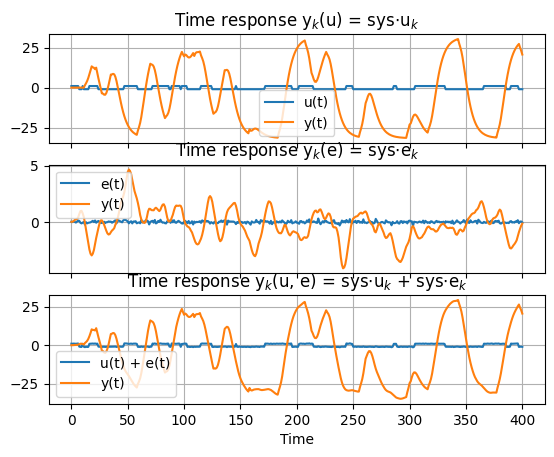

In [3]:
fig = plot_responses(
    time,
    [Usim, Uerr, Utot],
    [Ysim, Yerr, Ytot],
    ["u", "e", ["u", "e"]],
)

## Perform system identification from collected data

In [4]:
sys_id = system_identification(
    Ytot,
    Usim,
    "ARMAX",
    *((1, 5), (1, 5), (1, 5), (1, 13)),
    IC="BIC",
    centering="MeanVal",
    max_iter=1000,
)

## Check that output of the identified system is consistent

In [5]:
Y_id1, time, Xsim = cnt.lsim(sys_id.G, Usim, time)
Y_hid1, time, Xsim = cnt.lsim(sys_id.H, Uerr, time)
Y_idTot = Y_id1 + Y_hid1

/opt/pysetup/.venv/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


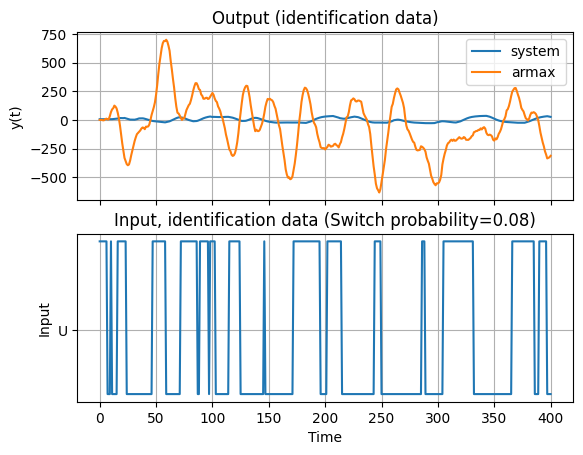

In [6]:
fig = plot_response(
    time,
    [Ytot, Y_idTot],
    Usim,
    legends=[["system", "armax"], ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.08)",
    ],
)

# Validation of the identified system: 
## Generate new time series for input and noise

In [7]:
switch_probability = 0.07  # [0..1]
input_range = [0.5, 1.5]
U_valid, _, _ = gen_gbn_seq(n_samples, switch_probability, scale=input_range)
white_noise_variance = [0.01]
e_valid = white_noise_var(U_valid.size, white_noise_variance)[0]

## Compute time responses for true system with new inputs

In [8]:
Yvalid1, time, Xsim = cnt.lsim(g_sys, U_valid, time)
Yvalid2, time, Xsim = cnt.lsim(h_sys, e_valid, time)
Ytotvalid = Yvalid1 + Yvalid2

## Compute time responses for identified system with new inputs

In [9]:
y_idvalid1, time, Xsim = cnt.lsim(sys_id.G, U_valid, time)
y_idvalid2, time, Xsim = cnt.lsim(sys_id.H, e_valid, time)
y_idtotvalid = y_idvalid1 + y_idvalid2

## Check responses are almost equal

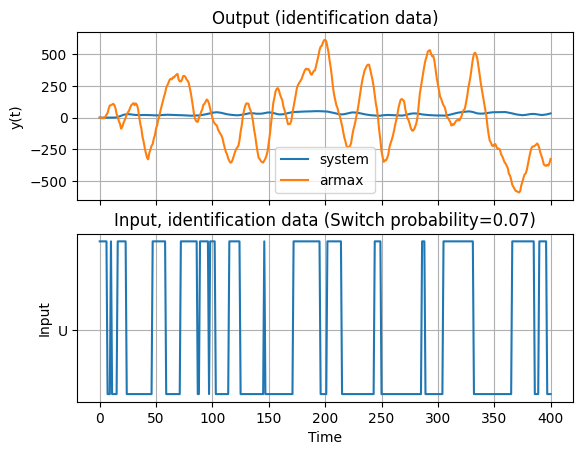

In [10]:
fig = plot_response(
    time,
    [Ytotvalid, y_idtotvalid],
    Usim,
    legends=[["system", "armax"], ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.07)",
    ],
)

/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: Fu

/opt/pysetup/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")
/opt/pysetup/.venv/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


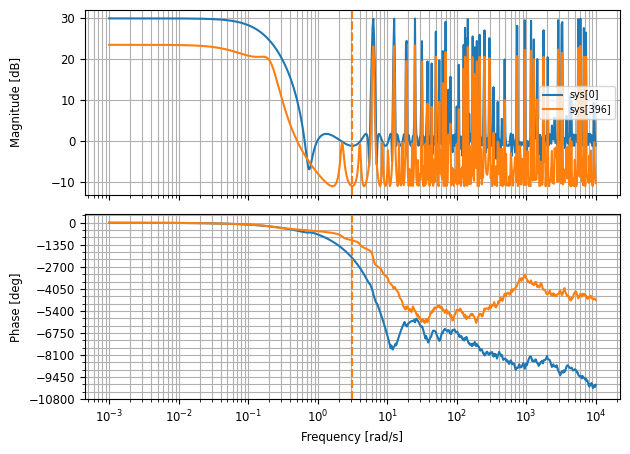

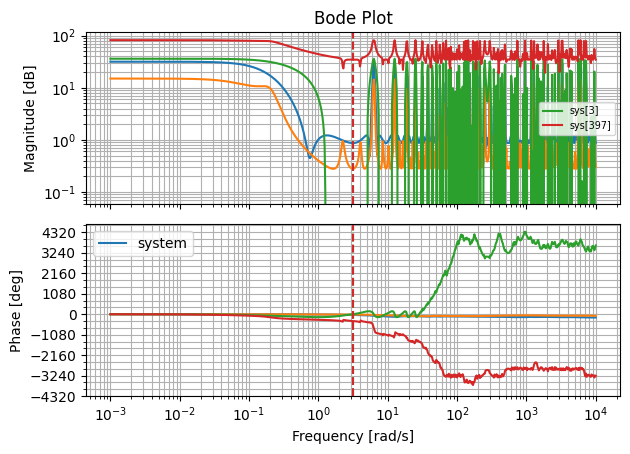

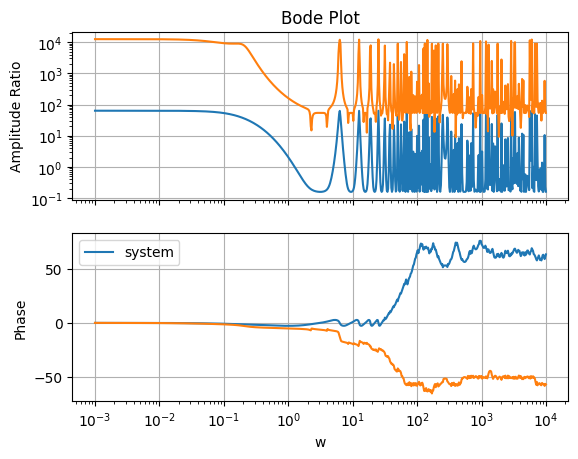

In [11]:
W_V = np.logspace(-3, 4, num=701)
for tf in ["G", "H"]:
    syss_tfs = [
        locals()[f"{tf.lower()}_sys"],
        getattr(sys_id, tf),
    ]
    mags, fis, oms = zip(*[cnt.bode(sys, W_V) for sys in syss_tfs])

    fig = plot_bode(
        oms[0],
        mags,
        fis,
        ["system"],
    )